# **Convolutional Neural Network for Market Forecasting**

One of class of algorithm that is not proposed yet is Convolutional Neural Networks. I came across [this paper](https://iopscience.iop.org/article/10.1088/1757-899X/435/1/012026/pdf) by Chen & al. and decided to give it a try. They use 1D CNN to forecast Chinese stock market from 05/25/2017 to 12/29/2017 with an accuracy close to 74%. I tried to extract their model architecture and hyperparemeters as accurately as possible and reproduced the network using sklearn and keras.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU

## Data shaping & data management

In [2]:
# Load information about the stock
stonks = 'fdx.us.txt'
df = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/'+stonks)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547 entries, 0 to 9546
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     9547 non-null   object 
 1   Open     9547 non-null   float64
 2   High     9547 non-null   float64
 3   Low      9547 non-null   float64
 4   Close    9547 non-null   float64
 5   Volume   9547 non-null   int64  
 6   OpenInt  9547 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 522.2+ KB
None


In [3]:
# Compute labels automatically based on the method given in the paper
# If value is greater 10 day ahead then label current day "buy (1)" otherwise "sell (0)"
df['Open10'] = df['Open'].shift(periods=-10)
df = df.dropna()
df['label'] = np.where(df['Open'] < df['Open10'], 1, 0)


# Drop useless columns, keeping only OHLCV
dropCols= ['Date', 'OpenInt', 'Open10'] # 'Open', 'High', 'Low', 'Close', 'Volume'
df = df.drop(labels=dropCols, axis=1)
print(df.head())

     Open    High     Low   Close   Volume  label
0  2.6409  2.7745  2.6409  2.6791   414703      1
1  2.6791  2.7367  2.6025  2.7367  1078568      1
2  2.7465  2.9375  2.7465  2.9086  1008335      1
3  2.9185  2.9659  2.9185  2.9375   449822      1
4  2.9375  3.0428  2.9185  3.0428   613695      1


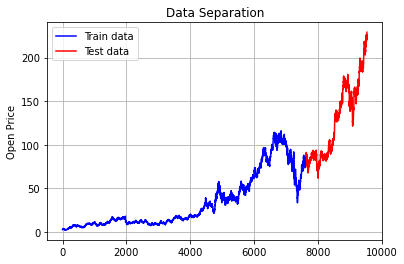

In [4]:
# Computing split index
x, _ = df.shape
splitCoeff = 0.80
splitRow = int(x * splitCoeff)
dfNum = df.to_numpy()

# Separating training data from testing data
trainX = dfNum[:splitRow, :-1]
trainY = dfNum[:splitRow, -1]
testX = dfNum[splitRow:, :-1]
testY = dfNum[splitRow:, -1]

# Showing price figure for 'open' prices
xPlot = range(0, x)
plt.figure()
plt.title('Data Separation')
plt.grid(True)
plt.ylabel('Open Price')
plt.plot(xPlot[:splitRow], trainX[:,0], 'blue', label='Train data')
plt.plot(xPlot[splitRow:], testX[:,0], 'red', label='Test data')
plt.legend()
plt.show()
plt.close()

In [5]:
# Input normalization
norm = MinMaxScaler()
trainX = norm.fit_transform(trainX)

# Reshaping data to get a 3D tensor for Conv1D
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# Parameters
nFeatures = trainX.shape[1]
epochs = 20
batchSize = 1000
nOutput = 1
kernelSize = 1

## Building the network

In [6]:
# Model Building
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(nFeatures, 1)))
model.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(filters=128, kernel_size=kernelSize, padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(Flatten())
model.add(Dense(256,))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.8))
model.add(Dense(nOutput, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Fit the model
fitReturn = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochs, batch_size=batchSize, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             2112      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 64)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            8320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0

## Results Exploitation

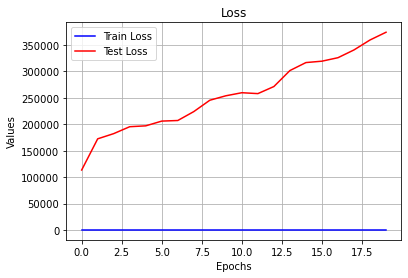

In [7]:
plt.title('Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['loss'], 'blue', label='Train Loss')
plt.plot(fitReturn.history['val_loss'], 'red', label='Test Loss')
plt.legend()
plt.show()
plt.close()

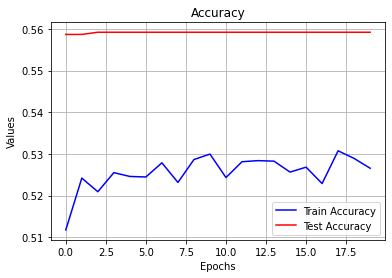

In [8]:
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['accuracy'], 'blue', label='Train Accuracy')
plt.plot(fitReturn.history['val_accuracy'], 'red', label='Test Accuracy')
plt.legend()
plt.show()
plt.close()

In [9]:
# Predictions
predictY = model.predict_classes(testX, verbose=0)
predictY = predictY[:, 0]

# Basic Counting
testY0 = (testY == 0).sum()
testY1 = (testY == 1).sum()
print("Test Set - Sell signal : "+str(testY0))
print("Test Set - Buy signal  : "+str(testY1))
print("="*40)
predictY0 = (predictY == 0).sum()
predictY1 = (predictY == 1).sum()
print("Predicted - Sell signal : "+str(predictY0))
print("Predicted - Buy signal  : "+str(predictY1))

Test Set - Sell signal : 842
Test Set - Buy signal  : 1066
Predicted - Sell signal : 1
Predicted - Buy signal  : 1907


In [10]:
# Computing Scores
accuracy = accuracy_score(testY, predictY)
precision = precision_score(testY, predictY)
recall = recall_score(testY, predictY)
f1 = f1_score(testY, predictY)
matrix = confusion_matrix(testY, predictY)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('F1 Score: '+str(f1))
print(matrix)

Accuracy: 0.5592243186582809
Precision: 0.5589931830099633
Recall: 1.0
F1 Score: 0.7171207534476959
[[   1  841]
 [   0 1066]]
